### brunch 작가 데이터 수집 
1. 브런치 follower, following 정보 수집 
1. 브런치 작기 정보 수집

In [1]:
import urllib
import requests
import json
from bs4 import BeautifulSoup
import pandas as pd
import seaborn as sns, numpy as np

import matplotlib.pylab as plt
%matplotlib inline

In [2]:
from selenium import webdriver
from selenium.webdriver.support.ui import Select
import time


1. 브런치 Follower(구독자), Following(관심작가) 정보 수집 
```html
<ul class="list_follow">객체에서
a tag href="/@"으로 시작하는 아이디 가져오기
```
<img src='https://t1.daumcdn.net/thumb/R1280x0/?fname=http://t1.daumcdn.net/brunch/service/user/Kvs/image/vS4eDK8M1R8ytc0HUJTlG8Vk-jg.png'>

* crawling 절차
 * https://brunch.co.kr/@{user-id}/{following} URL로 HTML을 크롤링한다. 
    : brunch 관심작가, 구독자가 공개는 되어 있지만, 무한 스크롤 방식의 UX를 사용하기 때문에 셀리늄2.0(webdriver)를 통해 html을 크롤링할수 있다. 
 * 크롤링된 HTML을 BS4로 class = link_follow 이고 herf = '@****' 로 시작되는 아이디만 추출
 

In [14]:
# brunch data crawling by 셀레니엄
# source reference : http://stackoverflow.com/questions/12519074/scrape-websites-with-infinite-scrolling
def crawlBrunchLink(uid, dir='follower', driver=webdriver.Firefox()):
    ## html crawling
    #driver = webdriver.Firefox()
    #driver.implicitly_wait(30)
    url = "https://brunch.co.kr/@{uid}/{dir}".format(uid=uid, dir=dir)
    driver.get(url)

    htmlsize = 0
    keep_cnt = 0
    for i in range(1,200):
        driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
        time.sleep(0.003) 
        if htmlsize == len(driver.page_source):
            keep_cnt += 1
        else :
            keep_cnt = 0
            htmlsize = len(driver.page_source)
        if keep_cnt > 5 :
            break
            
    html_source = driver.page_source
    ## extract follower, following data
    data = html_source.encode('utf-8')
    soup = BeautifulSoup(data, 'html.parser')
    classes = soup.find_all("a", class_="link_follow")
    idlist = []
    for c in classes:
        follwing = c.get('href')
        if follwing is None or len(follwing)==0:
            continue
        idlist.append(follwing[2:])

    #driver.close()
    return idlist

## goodvc78 follower(구독자) 크롤링 
driver = webdriver.Firefox()
crawlBrunchLink('goodvc78', dir='follower', driver=driver)
driver.close()

[u'kaldokim',
 u'daeheejang',
 u'biggold',
 u'onsykim',
 u'dosirak48',
 u'snowyn',
 u'junghojin07',
 u'yunkyungchoo89',
 u'drive0822',
 u'tkdgur4848',
 u'lotussoul',
 u'namwh',
 u'flowday',
 u'handojung',
 u'sean',
 u'minwoohong',
 u'dannykwon',
 u'rollanz',
 u'nuribit',
 u'visionholic',
 u'brunchdnku',
 u'wjchee',
 u'arowon',
 u'hyochulbang',
 u'yourbestkim',
 u'choikop',
 u'ltj880305',
 u'iamq3xc',
 u'brunchf4yz',
 u'driver97',
 u'brunchbifj',
 u'sangchung',
 u'dsuh',
 u'brunchezwn',
 u'redreamer',
 u'leehs1017',
 u'winter',
 u'jephrix',
 u'lobojeong',
 u'haaagood',
 u'cheonxtqj',
 u'rainfk',
 u'brunchjklr',
 u'kk760105',
 u'chajy815',
 u'imagineer',
 u'lightandsalt74',
 u'wmkim86rmaa',
 u'wholeman',
 u'paranoeac',
 u'jiyoung9z1p',
 u'sooen90',
 u'reading15m',
 u'brunch7se0',
 u'dongchimi',
 u'matthewjeong',
 u'jts87',
 u'sooyoungpark',
 u'kylef0im',
 u'ring801112',
 u'brunchw2ia',
 u'jaeyeonkim',
 u'johanguk',
 u'jeongsy10sqhn',
 u'vista4336',
 u'webyi',
 u'comfreak27',
 u'jakewpark

In [4]:
## 관심 작가 정보 크롤링 하기 
## extract Brunch Writer Info : uid, name, text-count, megazine-count, follower-count, following-count:
def extractWriterInfo(uid):
    try:
        response = requests.get("http://brunch.co.kr/@{uid}".format(uid=uid) )
    except Exception:
        []
        
    data = response.content.decode('utf-8')
    soup = BeautifulSoup(data, 'html.parser')
    
    ## name 
    names = soup.find_all("strong", class_="profileUserName")
    name = uid if len(names)<1 else names[0].getText()
    
    classes = soup.find_all("span", class_="num_count")
    reserved = [uid, name]
    for c in classes:
        reserved.append(int(c.getText()))
    return reserved

print extractWriterInfo('goodvc78')

['goodvc78', u'\ucd5c\uaddc\ubbfc', 3, 1, 164, 8]


* 관심 작가의 구독자 리스트 가져오기 

In [5]:
base = 'goodvc78'
base_follower = crawlBrunchLink(base,dir='follower')
print ("내가 좋아하는 작가의 followers = %d" %  len(base_follower) )

내가 좋아하는 작가의 followers = 164


In [6]:
print(base_follower[:4])

[u'kaldokim', u'daeheejang', u'biggold', u'onsykim']


In [16]:
## 관심 작가의 구독자(follower)를 크롤링하고
## 구독자가 등록한 관심작가(following)을 크롤링한다. 

def crawlwriter( uid ) :
    driver = webdriver.Firefox()
    ## read own follower
    follower = crawlBrunchLink(uid, dir='follower', driver=driver)
    
    ## start crawling 
    data = {}
    current = 0
    follower_cnt = len(follower)
    for n in follower[:]:
        followers = crawlBrunchLink( n, 'following', driver=driver )
        data[n] = { 'following': followers }
        current += 1
        print ( "{2} : {0}/{1}".format(current, follower_cnt, uid) )
    driver.close()
    return data

In [17]:
## goodvc78의 구독자리스트를 크롤링하고, 그 구독자의 관심작가 리스트를 크롤링한다. 
ds = {}
ds['goodvc78'] = crawlwriter('goodvc78')

goodvc78 : 1/164
goodvc78 : 2/164
goodvc78 : 3/164
goodvc78 : 4/164
goodvc78 : 5/164
goodvc78 : 6/164
goodvc78 : 7/164
goodvc78 : 8/164
goodvc78 : 9/164
goodvc78 : 10/164
goodvc78 : 11/164
goodvc78 : 12/164
goodvc78 : 13/164
goodvc78 : 14/164
goodvc78 : 15/164
goodvc78 : 16/164
goodvc78 : 17/164
goodvc78 : 18/164
goodvc78 : 19/164
goodvc78 : 20/164
goodvc78 : 21/164
goodvc78 : 22/164
goodvc78 : 23/164
goodvc78 : 24/164
goodvc78 : 25/164
goodvc78 : 26/164
goodvc78 : 27/164
goodvc78 : 28/164
goodvc78 : 29/164
goodvc78 : 30/164
goodvc78 : 31/164
goodvc78 : 32/164
goodvc78 : 33/164
goodvc78 : 34/164
goodvc78 : 35/164
goodvc78 : 36/164
goodvc78 : 37/164
goodvc78 : 38/164
goodvc78 : 39/164
goodvc78 : 40/164
goodvc78 : 41/164
goodvc78 : 42/164
goodvc78 : 43/164
goodvc78 : 44/164
goodvc78 : 45/164
goodvc78 : 46/164
goodvc78 : 47/164
goodvc78 : 48/164
goodvc78 : 49/164
goodvc78 : 50/164
goodvc78 : 51/164
goodvc78 : 52/164
goodvc78 : 53/164
goodvc78 : 54/164
goodvc78 : 55/164
goodvc78 : 56/164
g

In [18]:
def toDataframe(src) :
    data = []
    for n, f in src.items():
        for nn in f['following']:
            data.append([n,'following',nn])
    return pd.DataFrame(data, columns=['uid','dir','target'])

In [19]:
ds_goodvc78 = toDataframe( ds['goodvc78'])

In [22]:
ds_goodvc78.head()

,uid,dir,target
0,bskim987,following,goodvc78
1,bskim987,following,brunch
2,lotussoul,following,goodvc78
3,lotussoul,following,insuk
4,lotussoul,following,sunnysideup


### 평균 관심작수 등록수, 평균 구독자 수 

In [23]:
## 관심 작가 통계
ds_goodvc78.groupby(['uid']).count().describe()[['target']]

,target
count,164.000000
mean,29.006098
std,53.483269
min,2.000000
25%,5.000000
50%,12.000000
75%,28.000000
max,386.000000


skew = 4.53832936466


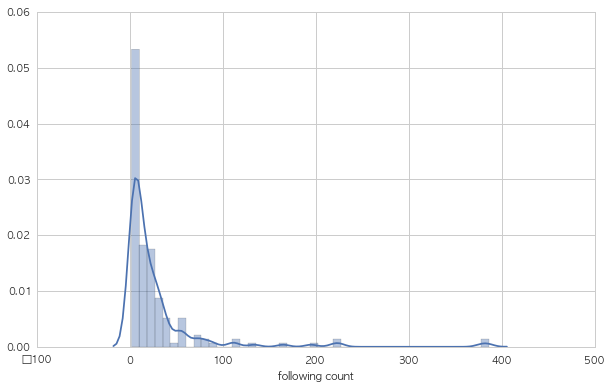

In [26]:
import seaborn as sns, numpy as np
from matplotlib import rcParams
sns.set_style("whitegrid")
rcParams['font.family'] = 'AppleGothic'
rcParams.update({'font.size': 12})
plt.figure(figsize=(10,6))
ax = sns.distplot(ds_goodvc78.groupby(['uid']).count().target )
ax.set_xlabel(u'following count')


print( 'skew = {0}'.format( ds_goodvc78.groupby(['uid']).count().target.skew()))

In [27]:
## filtering my-id and official-id ( goodvc78, brunch ) 
ds_goodvc78 = ds_goodvc78[~ds_goodvc78.target.isin(['goodvc78','brunch'])]

* 크롤링한 데이터 파일로 저장 

In [28]:
## 현재 경로 보기 명령어 실행 
!pwd

/Users/goodvc/Data/fc-recsys-school/ch1


In [29]:
### crawled data save
import pickle
output = open('/Users/goodvc/Data/fc-recsys-school/ch1/resource/brunch_sns.pkl', 'wb')
pickle.dump(ds, output)
output.close()

In [30]:
## road pickle data
pkl_file = open('/Users/goodvc/Data/fc-recsys-school/ch1/resource/brunch_sns.pkl', 'rb')
loaded = pickle.load(pkl_file)
pkl_file.close() 

In [31]:
loaded

{'goodvc78': {u'01134eo': {'following': [u'goodvc78', u'brunch']},
  u'aeterkhan': {'following': [u'sunsutu',
    u'goodvc78',
    u'snowcountry',
    u'plusclov',
    u'jmh5531',
    u'head77x',
    u'brunch']},
  u'akuku': {'following': [u'haneulalice',
    u'goodvc78',
    u'jnbells',
    u'sadrove',
    u'vijay',
    u'borashow',
    u'yper',
    u'sophia5787',
    u'brunch']},
  u'ami': {'following': [u'dj0999',
    u'sustainlife',
    u'2kija',
    u'goodvc78',
    u'cinehvwm',
    u'suyoung',
    u'dalda',
    u'suhanjang',
    u'yunjungseo',
    u'jimmyrim',
    u'sooscape',
    u'meanimize',
    u'brunch']},
  u'arowon': {'following': [u'goodvc78', u'brunch']},
  u'biggold': {'following': [u'sungwooan',
    u'reinitiate',
    u'timotolkie',
    u'goodvc78',
    u'npulen',
    u'brunchnwkd',
    u'dndb21',
    u'kyeongwook-ma',
    u'hakawati',
    u'lwh0416',
    u'jowlee',
    u'wanleehani',
    u'kimjiyoun',
    u'kkonal',
    u'toriteller',
    u'matt',
    u'sjmsg',
    u'